# Geometric Transformers

You can run this notebook directly on Google Colab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DaniAffCH/Vessel-Geometric-Transformers/blob/main/main.ipynb)

## Index

### Geometric Algebra 
- [geometricAlgebraElements](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/geometricAlgebraElements.py) defines how geometric objects and transformations can be embedded into projective geometric algebra
- [geometricAlgebraOperations](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/geometricAlgebraOperations.py) defines operations between multivectors

### [Dataset](#dataset) 
- [dataset](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/data/dataset.py) downloads the dataset into .hdf5 files and shuffles the labels 
- [datamodule](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/data/datamodule.py) is the class where raw data is embedded into geometric algebra and then collected into batches by the dataloaders

### Layers
- [default](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models/layers/default) where layers for the baseline transformer are implemented
- [geometric](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models/layers/geometric) where all the layers equivariant to the E(3) symmetry group are implemented

### [Equivariance](#equivariance-check)
- [equivariance](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/lib/equivariance.py) check utility functions, where transformations against which equivariance must hold are implemented
- [tests](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/test/test_equivariance.py) to check equivariance

### [Models](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/src/models)

In [2]:
import sys
import warnings

warnings.filterwarnings('ignore')

COLAB_RUNTIME = 'google.colab' in sys.modules
!nvidia-smi &> /dev/null || echo -e "\e[31mWarning: No GPU found. Please check your runtime settings.\e[0m"
if COLAB_RUNTIME:
    !git config --global init.defaultBranch main
    !git init
    !git remote add origin https://github.com/DaniAffCH/Vessel-Geometric-Transformers.git
    !git pull origin main
    !pip install -q -r requirements.txt
else: # Development mode, setting precommit checks 
    !pip install -q -r requirements.txt
    !pre-commit autoupdate
    !pre-commit install


[https://github.com/psf/black] already up to date!
[https://github.com/pycqa/isort] already up to date!
[https://github.com/PyCQA/flake8] already up to date!
[https://github.com/pre-commit/mirrors-mypy] already up to date!
pre-commit installed at .git/hooks/pre-commit


---

### Loading the configuration
- You can change by modifying this [yaml](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/config/config.yaml) file
- New entries should be added also [here](https://github.com/DaniAffCH/Vessel-Geometric-Transformers/blob/main/config/dataclasses.py)

In [3]:
from src.utils import load_config
import os
from lightning import seed_everything

config_path = os.path.join("config","config.yaml")
config = load_config(config_path)
seed_everything(config.seed)

Seed set to 123


123

---

### Loading the dataset
Showing data shapes and label distribution to check whether train, validation and test set are balanced

Train size: 2999
Val size: 599
Test size: 401
One Sample: Data(pos=[16671, 3], wss=[16671, 3], pressure=[16671], face=[3, 33338], inlet_index=[807], label=Category.Bifurcating)


100%|██████████| 3999/3999 [00:03<00:00, 1323.99it/s]


,Mean,Median,Std,Min,Max
WSS,13011.76019,11387.0,4271.667184,5466,24800
POS,13011.76019,11387.0,4271.667184,5466,24800
FACE,26019.52038,22770.0,8543.334368,10928,49596
PRESSURE,13011.76019,11387.0,4271.667184,5466,24800


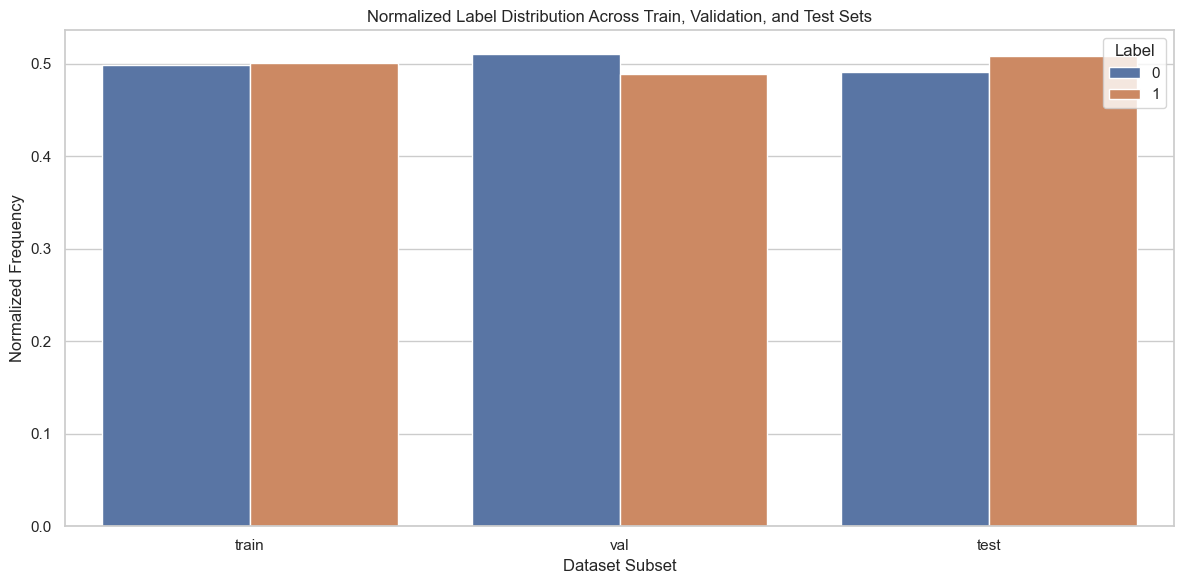

In [4]:
from src.data import VesselDataModule
from src.utils.data_analysis import data_info, check_class_distribution

data = VesselDataModule(config.dataset)
data_info(data)
check_class_distribution(data)

Plotting the data distribution projected in 2D using Principal Component Analysis.

Extracting Feature.FACE: 100%|██████████| 3999/3999 [00:03<00:00, 1156.47it/s]


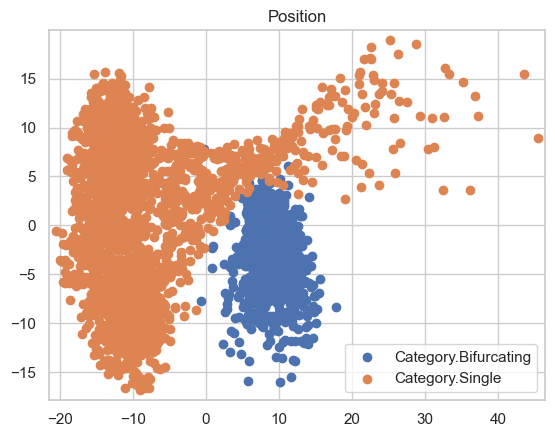

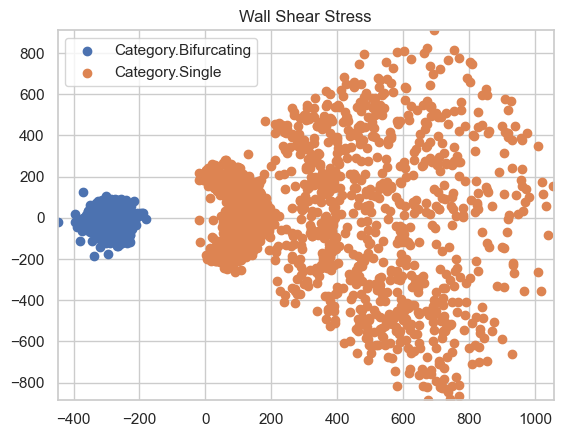

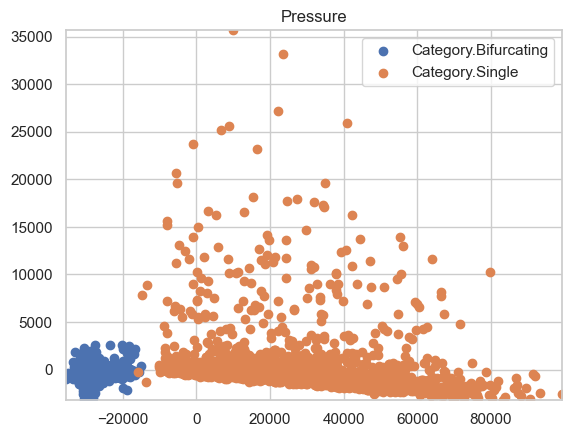

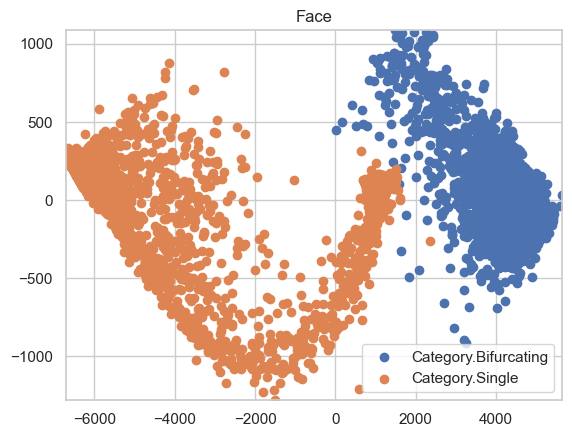

In [5]:
from src.utils.definitions import Feature, Category
from src.utils.data_analysis import plot_data

wss, labels = data.extract_feature(Feature.WSS)
pos, labels = data.extract_feature(Feature.POS)
pressure, labels = data.extract_feature(Feature.PRESSURE)
face, labels = data.extract_feature(Feature.FACE)
plot_data(pos, labels, Category, "Position")
plot_data(wss, labels, Category, "Wall Shear Stress")
plot_data(pressure, labels, Category, "Pressure")
plot_data(face, labels, Category, "Face")

---

### Equivariance Check
Performing equivariance check using random samples from the dataset.  
Geometric Layer is expected to fail due to lack of distance-aware dot product

In [10]:
from src.lib.geometricAlgebraElements import GeometricAlgebraBase
from src.test.test_equivariance import TestEquivariance
import unittest

dl = data.train_dataloader()
batch = next(iter(dl)).data[0]
batch = batch.view(-1, GeometricAlgebraBase.GA_size)[:10] # Flattening and taking only the first 10 elements
TestEquivariance.INPUT_DATA = batch # Setting the input data for the test

suite = unittest.TestSuite()
suite.addTests(unittest.TestLoader().loadTestsFromTestCase(TestEquivariance))
test_runner = unittest.TextTestRunner(verbosity=0)
restResult = test_runner.run(suite)


✅ GeometricBilinearLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]

✅ EquiLinearLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]

✅ EquiNormLayer passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]


FAIL: test_geomattention_layer (src.test.test_equivariance.TestEquivariance.test_geomattention_layer)
Tests the equivariance of the GeometricAttentionLayer.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/home/neverorfrog/code/deep-learning/gatr/src/test/test_equivariance.py", line 125, in test_geomattention_layer
    self.assertTrue(
AssertionError: False is not true : GeometricAttentionLayer failed the equivariance                     test for input 1

----------------------------------------------------------------------
Ran 5 tests in 3.815s

FAILED (failures=1)



✅ GatedGELU passed all equivariance tests               with a tolerance of 1e-05.              [10 inputs, 100 checks each]


---

### MLP Baseline

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [ ]:
from src.utils.hpo import mlp_hpo

mlp_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

Training the model using the best hyperparameters

In [ ]:
from src.trainer import VesselTrainer
from src.models import BaselineMLP

model = BaselineMLP(config.mlp)
trainer = VesselTrainer(config.trainer, "mlp")
trainer.fit(model, data)

Test the model performance on unseen test data.

In [ ]:
trainer.test(model, data)

### Attention based Baseline

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [ ]:
from src.utils.hpo import baseline_hpo

baseline_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

Training the model using the best hyperparameters

In [ ]:
from src.trainer import VesselTrainer
from src.models import BaselineTransformer

model = BaselineTransformer(config.baseline)
trainer = VesselTrainer(config.trainer, "transformer")
trainer.fit(model, data)

Test the model performance on unseen test data.

In [ ]:
trainer.test(model, data)

---

### GATr

Running hyperparameter optimization to find the best hyperparameters maximizing the validation accuracy

In [ ]:
from src.models import Gatr
from src.utils.hpo import gatr_hpo

gatr_hpo(config, data) # Hyperparameter optimization: writes the config file with the best hyperparameters

Training the model using the best hyperparameters

In [ ]:
from src.trainer import VesselTrainer

model = Gatr(config.gatr)
trainer = VesselTrainer(config.trainer, "gatr")
trainer.fit(model, data)

Test the model performance on unseen test data.

In [ ]:
trainer.test(model, data)

----